# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

### Imports

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import datetime as dt
import numpy as np 

### Stations' Plot

In [2]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()
leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

### Read Data

In [3]:
debug = 1 
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
if debug:
    print(df.shape)
    print("---------------------------------------------")
    print(df.head())
    print("---------------------------------------------")
    print(df.info())

(165085, 4)
---------------------------------------------
            ID        Date Element  Data_Value
0  USW00094889  2014-11-12    TMAX          22
1  USC00208972  2009-04-29    TMIN          56
2  USC00200032  2008-05-26    TMAX         278
3  USC00205563  2005-11-11    TMAX         139
4  USC00200230  2014-02-27    TMAX        -106
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
ID            165085 non-null object
Date          165085 non-null object
Element       165085 non-null object
Data_Value    165085 non-null int64
dtypes: int64(1), object(3)
memory usage: 5.0+ MB
None


### Helper Methods

In [4]:
## Preparation Helper Method
def get_min_max(df_input):
    # Split df_input into two dataframes
    # df_max for Max values 
    df_max = df_input[df_input['Element']=='TMAX'].copy()
    # df_min for Min values
    df_min = df_input[df_input['Element']=='TMIN'].copy()
    
    if debug:
        print("Max:")
        print(df_max.head())
        print(df_max.shape)
        print("---------------------------------------------")
        print("Min:")
        print(df_min.head())
        print(df_min.shape)
        print("---------------------------------------------")
    
    # Join df_min & df_max two discard rows that exist in any df
    # but does not exist in the other
    z = pd.merge(df_min,df_max,on=['ID','Date'])
    if debug:
        print("Merged Df:")
        print(df_max.head())
        print(df_max.shape)
        print("---------------------------------------------")
        
    # Split merged dfs again and rename columns back to their old names
    df_max = z[['ID','Day_Mon_y', 'Date', 'Element_y','Data_Value_y']].copy()
    df_max.columns=['ID','Day_Mon', 'Date', 'Element','Data_Value']
    df_min = z[['ID','Day_Mon_x', 'Date', 'Element_x','Data_Value_x']].copy()
    df_min.columns=['ID','Day_Mon', 'Date', 'Element','Data_Value']
    
    # Multiply by 0.1 because Temps are provided in tenths of degrees C
    df_max['Data_Value'] = df_max['Data_Value']*0.1
    df_min['Data_Value'] = df_min['Data_Value']*0.1
    
    # Aggregation
    top_min = df_min.groupby(['Day_Mon', 'Element']).agg({'Data_Value':np.min})['Data_Value']
    top_max = df_max.groupby(['Day_Mon', 'Element']).agg({'Data_Value':np.max})['Data_Value']
    if debug:
        print("Aggregated Min Temp/Day:")
        print(top_min.describe())
        print("---------------------------------------------")
        print("Aggregated Max Temp/Day:")
        print(top_max.describe())
    return top_min.values, top_max.values

## Plotting Helper Methods
def line_plot(df_input_min, df_input_max):
    # Plot Min Temps Line
    line_plt = plt.plot(df_input_min, '-', color='skyblue', label = 'Min 2005-2014')
    # Plot Max Temps Line
    line_plt = plt.plot(df_input_max,'-', color='lightcoral', label = 'Max 2005-2014')   
    # Fill in between
    sh = plt.gca().fill_between(range(len(df_input_min)), df_input_min, df_input_max, facecolor='gainsboro', alpha=0.25)
    
    
def scatter_plot(df_input_min1, df_input_max1, df_input_min2, df_input_max2):
    # Convert into Dataframes for easier comparisons
    df_min1 = pd.DataFrame(df_input_min1)
    df_min2 = pd.DataFrame(df_input_min2)
    df_max1 = pd.DataFrame(df_input_max1)
    df_max2 = pd.DataFrame(df_input_max2)
    # Filter days where Min record in 2014 is broken in 2015
    df_scatter_min = df_min2[df_min2[0]<df_min1[0]]
    # Plot min points breaking records
    plt.scatter(df_scatter_min.index, df_scatter_min, s=30, c='navy', label = '2015 below Min')    
    # Filter days where Max record in 2014 is broken in 2015
    df_scatter_max = df_max2[df_max2[0]>df_max1[0]]    
    # Plot max points breaking records
    plt.scatter(df_scatter_max.index, df_scatter_max, s=30, c='firebrick', label = '2015 above Max')
    

### Prepare Data

In [5]:
## Change to Datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Day_Mon'] = df['Date'].dt.strftime('%m-%d')

# Drop Leaps
if debug:
    print("Before Leaps Drop:")
    print(df[(pd.DatetimeIndex(df['Date']).day == 29) & (pd.DatetimeIndex(df['Date']).month == 2)])
leaps = df[(pd.DatetimeIndex(df['Date']).day == 29) & (pd.DatetimeIndex(df['Date']).month == 2)].index
df = df.drop(df.index[leaps])
if debug:
    print("After Leaps Drop:")
    print(df[(pd.DatetimeIndex(df['Date']).day == 29) & (pd.DatetimeIndex(df['Date']).month == 2)])
print("---------------------------------------------")

## Split Data into 
# 2005-2014 Dataframes
df_2014 = df[(df['Date']>=dt.date(2005,1,1)) & (df['Date']<dt.date(2015,1,1))].copy()
if debug:
    print("2014:")
    print(df_2014.head())
    print(df_2014.shape)
    print("---------------------------------------------")
top_min_2014, top_max_2014 = get_min_max(df_2014)
# 2015 Dataframes
df_2015 = df[(df['Date']>=dt.date(2015,1,1)) & (df['Date']<dt.date(2016,1,1))].copy()
if debug:
    print("2015:")
    print(df_2015.head())
    print(df_2015.shape)
    print("---------------------------------------------")
top_min_2015, top_max_2015 = get_min_max(df_2015)



Before Leaps Drop:
                 ID       Date Element  Data_Value Day_Mon
18712   USC00205563 2012-02-29    TMAX          39   02-29
18716   USC00200842 2012-02-29    TMIN         -56   02-29
18729   USC00205563 2012-02-29    TMIN          -6   02-29
18730   USC00200842 2012-02-29    TMAX          61   02-29
18812   USC00208080 2012-02-29    TMIN         -44   02-29
18817   USC00208080 2012-02-29    TMAX          78   02-29
18942   USC00205451 2012-02-29    TMAX          44   02-29
18962   USC00205451 2012-02-29    TMIN         -50   02-29
19014   USC00201502 2012-02-29    TMIN         -17   02-29
19016   USC00201502 2012-02-29    TMAX          61   02-29
19063   USC00200230 2012-02-29    TMIN           0   02-29
19066   USC00200230 2012-02-29    TMAX          56   02-29
19115   USW00094889 2012-02-29    TMIN           6   02-29
19117   USW00094889 2012-02-29    TMAX          83   02-29
19531   USW00004848 2012-02-29    TMIN          17   02-29
19534   USW00004848 2012-02-29    TMA

### Plotting

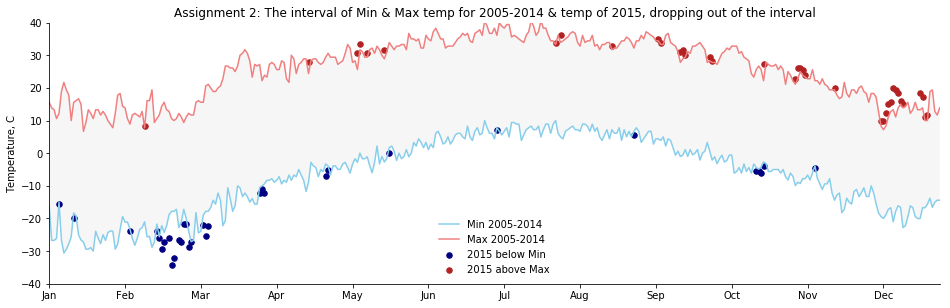

In [6]:
plt.figure(figsize = (13, 7), facecolor = None) 
_ = line_plot(top_min_2014, top_max_2014)
_ = scatter_plot(top_min_2014,top_max_2014,top_min_2015,top_max_2015)
plt.gca().axis([0,364,-40,40])
_ = plt.gca().set_xticks(np.arange(start=0, stop=365, step=31).tolist())
_ = plt.gca().set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)    
plt.gca().set_title('Assignment 2: The interval of Min & Max temp for 2005-2014 & temp of 2015, dropping out of the interval')
plt.gca().set_ylabel('Temperature, C')
plt.tight_layout(pad = 0) 
plt.subplots_adjust(bottom=0.45)
_ = plt.legend(loc=8, frameon=False)
plt.show()